<a href="https://colab.research.google.com/github/anshsharmacse/AI-powered-Digital-Microscope-and-Molecular-Simulations/blob/main/Digitalmicroscope.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI powered Digital Microscope and Molecular Simulations
---
# Created by - Ansh Sharma

> Project Description
# Molecular Simulation with Graph Neural Networks

* **Input:** Enter any biological molecule name (benzene, aspirin, etc.)
* **Data Source:** Automatically retrieves molecular data from PubChem
* **Core Technology:** Custom Message Passing Neural Network for molecular property prediction
* **Graph Representation:** Converts molecules to graphs where atoms are nodes and bonds are edges

## Key Features:
* No local datasets required - direct PubChem integration
* Predicts properties like molecular weight, LogP, polar surface area
* Performs conformer analysis to identify energetically favorable 3D structures
* Interactive 2D and 3D visualization using RDKit and py3Dmol
* Displays predicted vs. actual properties with error metrics

## Benefits:
* Learns complex molecular structure-property relationships
* Visualizes spatial arrangements of atoms from multiple angles
* Accessible to both experts and beginners in computational chemistry
* Thoroughly commented, step-by-step code organization
* Requires no specialized software or programming expertise


---

For further Information ▶ Please Contact
*   Ansh Sharma - Btech NIT Calicut , Minor in CSE IIT Mandi - 🇮🇳
*   Gmail - anshsharmacse@gmail.com
*   Linkedin: https://www.linkedin.com/in/anshsharmacse/






---
# Installing Required Modules

In [ ]:
# Install required packages
!pip install rdkit-pypi
!pip install torch
!pip install torch-geometric torch-scatter torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cpu.html
!pip install pubchempy
!pip install matplotlib
!pip install py3Dmol
!pip install networkx

Looking in links: https://data.pyg.org/whl/torch-1.10.0+cpu.html
  Using cached torch_geometric-2.6.1-py3-none-any.whl.metadata (63 kB)
  Using cached torch_scatter-2.1.2.tar.gz (108 kB)
  Preparing metadata (setup.py) ... done
  Using cached torch_sparse-0.6.18.tar.gz (209 kB)
  Preparing metadata (setup.py) ... done
Using cached torch_geometric-2.6.1-py3-none-any.whl (1.1 MB)
  Created wheel for torch-scatter: filename=torch_scatter-2.1.2-cp311-cp311-linux_x86_64.whl size=547368 sha256=13218dee872653253f112d85960339d3bd9b4b9f689553a3e4d939daa19e3b17
  Stored in directory: /root/.cache/pip/wheels/b8/d4/0e/a80af2465354ea7355a2c153b11af2da739cfcf08b6c0b28e2
  Created wheel for torch-sparse: filename=torch_sparse-0.6.18-cp311-cp311-linux_x86_64.whl size=1127937 sha256=f975aa154b7d4d4e74f9dc54d787a694913e47c3f61e15e3ca186fcf9c699d4a
  Stored in directory: /root/.cache/pip/wheels/75/e2/1e/299c596063839303657c211f587f05591891cc6cf126d94d21
Successfully built torch-scatter torch-sparse


# **Importing The modules - Pubchem,Torch-Geometric**


---



In [ ]:
!pip install torch_geometric
import pubchempy as pcp
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, Descriptors, Lipinski
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data
from torch_geometric.nn import MessagePassing, global_mean_pool
from torch_geometric.utils import add_self_loops
import time
import io
import py3Dmol
from IPython.display import display


# Molecule Retrieval from Pubchem and Processings through RDkit

In [ ]:
def get_molecule_from_name(name):
    """Retrieve molecule from PubChem based on name"""
    try:
        compounds = pcp.get_compounds(name, 'name')
        if not compounds:
            return None, None

        # Get the first compound
        compound = compounds[0]
        smiles = compound.canonical_smiles

        # Convert to RDKit molecule
        mol = Chem.MolFromSmiles(smiles)
        if mol is None:
            return None, None

        # Add hydrogens and generate 3D coordinates
        mol = Chem.AddHs(mol)
        AllChem.EmbedMolecule(mol, randomSeed=42)
        AllChem.MMFFOptimizeMolecule(mol)

        return mol, compound
    except Exception as e:
        print(f"Error retrieving molecule: {e}")
        return None, None


#Molecular Graph Representation - for GNN

In [ ]:
def one_hot_encoding(value, choices):
    """Convert a value to one-hot encoding based on choices"""
    encoding = [0] * len(choices)
    index = choices.index(value) if value in choices else -1
    if index != -1:
        encoding[index] = 1
    return encoding

def atom_features(atom):
    """Generate atom features for GNN"""
    # Atom type one-hot encoding
    atom_type_one_hot = one_hot_encoding(
        atom.GetSymbol(),
        ['C', 'N', 'O', 'S', 'F', 'Si', 'P', 'Cl', 'Br', 'I', 'B', 'H']
    )

    # Atom degree one-hot encoding
    degree_one_hot = one_hot_encoding(
        atom.GetDegree(),
        [0, 1, 2, 3, 4, 5, 6]
    )

    # Formal charge
    formal_charge = [atom.GetFormalCharge()]

    # Hybridization one-hot encoding
    hybridization_one_hot = one_hot_encoding(
        str(atom.GetHybridization()),
        ['SP', 'SP2', 'SP3', 'SP3D', 'SP3D2']
    )

    # Is aromatic
    is_aromatic = [1 if atom.GetIsAromatic() else 0]

    # Combine all features
    features = atom_type_one_hot + degree_one_hot + formal_charge + hybridization_one_hot + is_aromatic

    return features

def bond_features(bond):
    """Generate bond features for GNN"""
    # Bond type one-hot encoding
    bond_type_one_hot = one_hot_encoding(
        str(bond.GetBondType()),
        ['SINGLE', 'DOUBLE', 'TRIPLE', 'AROMATIC']
    )

    # Is conjugated
    is_conjugated = [1 if bond.GetIsConjugated() else 0]

    # Is in ring
    is_in_ring = [1 if bond.IsInRing() else 0]

    # Stereo configuration
    stereo_one_hot = one_hot_encoding(
        str(bond.GetStereo()),
        ['STEREONONE', 'STEREOANY', 'STEREOZ', 'STEREOE']
    )

    # Combine all features
    features = bond_type_one_hot + is_conjugated + is_in_ring + stereo_one_hot

    return features

def mol_to_graph(mol):
    """Convert RDKit molecule to PyTorch Geometric graph"""
    # Get atom features
    atom_feats = []
    for atom in mol.GetAtoms():
        atom_feats.append(atom_features(atom))

    atom_feats = torch.tensor(atom_feats, dtype=torch.float)

    # Get edge indices and features
    edge_indices = []
    edge_feats = []

    for bond in mol.GetBonds():
        # Get bond indices (start atom, end atom)
        i = bond.GetBeginAtomIdx()
        j = bond.GetEndAtomIdx()

        # Add edges in both directions
        edge_indices.append((i, j))
        edge_indices.append((j, i))

        # Get bond features
        bond_feat = bond_features(bond)
        edge_feats.append(bond_feat)
        edge_feats.append(bond_feat)  # Same features for both directions

    # If no bonds, create empty tensors
    if len(edge_indices) == 0:
        edge_index = torch.zeros((2, 0), dtype=torch.long)
        edge_attr = torch.zeros((0, 10), dtype=torch.float)  # 10 is the length of bond features
    else:
        # Convert to PyTorch tensors
        edge_index = torch.tensor(edge_indices, dtype=torch.long).t().contiguous()
        edge_attr = torch.tensor(edge_feats, dtype=torch.float)

    # Create PyG data object
    data = Data(x=atom_feats, edge_index=edge_index, edge_attr=edge_attr)

    return data


# **Graph Neural Network Architecture**

In [ ]:
class MPNNConv(MessagePassing):
    """Message Passing Neural Network layer"""
    def __init__(self, node_dim, edge_dim, hidden_dim):
        super(MPNNConv, self).__init__(aggr='add')

        # Message function (node + edge features)
        self.message_fn = nn.Sequential(
            nn.Linear(node_dim + edge_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )

        # Update function
        self.update_fn = nn.Sequential(
            nn.Linear(node_dim + hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim)
        )

    def forward(self, x, edge_index, edge_attr):
        # Handle the case where there are no edges
        if edge_index.size(1) == 0:
            return torch.zeros_like(x)

        # Add self-loops to edge_index if there are edges
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Add zero features for self-loops
        self_loop_attr = torch.zeros((x.size(0), edge_attr.size(1)), device=edge_attr.device)
        edge_attr = torch.cat([edge_attr, self_loop_attr], dim=0)

        # Start propagating messages
        return self.propagate(edge_index, x=x, edge_attr=edge_attr)

    def message(self, x_j, edge_attr):
        # x_j: source node features
        # edge_attr: edge features

        # Concatenate node and edge features
        message_input = torch.cat([x_j, edge_attr], dim=1)

        # Apply message function
        return self.message_fn(message_input)

    def update(self, aggr_out, x):
        # aggr_out: aggregated messages
        # x: target node features

        # Concatenate node features and aggregated messages
        update_input = torch.cat([x, aggr_out], dim=1)

        # Apply update function
        return self.update_fn(update_input)

class MoleculeGNN(nn.Module):
    """GNN model for molecular property prediction"""
    def __init__(self, node_feat_dim, edge_feat_dim, hidden_dim, num_layers, output_dim):
        super(MoleculeGNN, self).__init__()

        # Initial node embedding
        self.node_embedding = nn.Linear(node_feat_dim, hidden_dim)

        # Message passing layers
        self.convs = nn.ModuleList()
        for _ in range(num_layers):
            self.convs.append(MPNNConv(hidden_dim, edge_feat_dim, hidden_dim))

        # Final prediction layers
        self.predict = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, data):
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr

        # Initial node embedding
        x = self.node_embedding(x)

        # Message passing
        for conv in self.convs:
            x_new = conv(x, edge_index, edge_attr)
            x = F.relu(x_new) + x  # Residual connection

        # Global pooling (mean of all node features)
        x = global_mean_pool(x, torch.zeros(data.num_nodes, dtype=torch.long))

        # Final prediction
        x = self.predict(x)

        return x


# **Molecular Property Calculation and Simulations**

In [ ]:
def calculate_molecular_properties(mol):
    """Calculate basic molecular properties using RDKit"""
    properties = {
        "Molecular Weight": Descriptors.MolWt(mol),
        "LogP": Descriptors.MolLogP(mol),
        "Num H-Donors": Lipinski.NumHDonors(mol),
        "Num H-Acceptors": Lipinski.NumHAcceptors(mol),
        "Num Rotatable Bonds": Descriptors.NumRotatableBonds(mol),
        "Topological Polar Surface Area": Descriptors.TPSA(mol),
        "Molar Refractivity": Descriptors.MolMR(mol),
        "Num Heavy Atoms": mol.GetNumHeavyAtoms(),
    }

    return properties

def simulate_molecule_properties(mol, simulation_params):
    """Simulate molecular properties using GNN and perform conformer analysis"""
    # Convert molecule to graph
    graph = mol_to_graph(mol)

    # Calculate actual properties using RDKit
    actual_properties = calculate_molecular_properties(mol)

    # Initialize property predictions dict
    property_predictions = {}

    # Prepare for GNN simulation
    if graph.edge_index.size(1) > 0:  # Make sure there are edges
        # Create GNN model
        model = MoleculeGNN(
            node_feat_dim=graph.x.size(1),
            edge_feat_dim=graph.edge_attr.size(1),
            hidden_dim=simulation_params["hidden_dim"],
            num_layers=simulation_params["num_layers"],
            output_dim=len(simulation_params["properties_to_predict"])
        )

        # Put model in evaluation mode
        model.eval()

        # Simulate forward pass (in real scenario, this would be trained)
        with torch.no_grad():
            outputs = model(graph).numpy().flatten()

            # Map outputs to properties with simulated noise
            for i, prop in enumerate(simulation_params["properties_to_predict"]):
                if prop in actual_properties:
                    value = actual_properties[prop]
                    noise_factor = simulation_params["noise_factor"]
                    noise = np.random.normal(0, noise_factor * max(0.01, abs(value)))
                    property_predictions[prop] = value + noise
    else:
        # For molecules with no bonds, just use the actual properties
        for prop in simulation_params["properties_to_predict"]:
            if prop in actual_properties:
                property_predictions[prop] = actual_properties[prop]

    # Generate conformers if requested
    if simulation_params["calculate_conformers"]:
        print("\nGenerating molecular conformers...")

        try:
            # Make a fresh copy of the molecule for conformer generation
            mol_copy = Chem.AddHs(Chem.Mol(mol))

            # Number of conformers to generate
            num_conformers = simulation_params["num_conformers"]

            # Generate conformers
            confs = AllChem.EmbedMultipleConfs(
                mol_copy,
                numConfs=num_conformers,
                useExpTorsionAnglePrefs=True,
                useBasicKnowledge=True,
                randomSeed=42,
                numThreads=0  # Use all available CPUs
            )

            if confs == -1 or confs == 0:
                print("Failed with advanced method, trying distance geometry...")
                confs = AllChem.EmbedMultipleConfs(
                    mol_copy,
                    numConfs=num_conformers,
                    useRandomCoords=True,
                    randomSeed=42,
                    numThreads=0
                )

            if confs == -1 or confs == 0:
                print("Could not generate conformers. Skipping conformer analysis.")
                simulation_results = {
                    "property_predictions": property_predictions,
                    "actual_properties": actual_properties
                }
                return simulation_results

            # Optimize conformers using force field
            results = []
            for conf_id in range(mol_copy.GetNumConformers()):
                ff = AllChem.MMFFGetMoleculeForceField(
                    mol_copy,
                    AllChem.MMFFGetMoleculeProperties(mol_copy),
                    confId=conf_id
                )
                ff.Minimize()
                energy = ff.CalcEnergy()
                results.append((conf_id, energy))

            # Sort by energy
            results.sort(key=lambda x: x[1])
            conformer_indices = [r[0] for r in results]
            conformer_energies = [r[1] for r in results]

            # Store results
            simulation_results = {
                "property_predictions": property_predictions,
                "actual_properties": actual_properties,
                "conformer_indices": conformer_indices,
                "conformer_energies": conformer_energies,
                "mol_with_conformers": mol_copy
            }

        except Exception as e:
            print(f"Error during conformer generation: {e}")
            simulation_results = {
                "property_predictions": property_predictions,
                "actual_properties": actual_properties
            }
    else:
        simulation_results = {
            "property_predictions": property_predictions,
            "actual_properties": actual_properties
        }

    return simulation_results


# 3D and 2D Visualizations using pyplot and py3Dmol and Conformer Analysis

In [ ]:
def visualize_molecule_2d(mol):
    """Visualize the molecular structure in 2D"""
    img = Draw.MolToImage(mol, size=(600, 400))
    plt.figure(figsize=(8, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title("2D Molecular Structure")
    plt.show()

def visualize_molecule_3d(mol, conf_id=0):
    """Visualize the molecular structure in 3D using py3Dmol"""
    # Generate mol block with 3D coordinates
    mb = Chem.MolToMolBlock(mol, confId=conf_id)

    # Create py3Dmol view
    view = py3Dmol.view(width=600, height=400)
    view.addModel(mb, 'mol')
    view.setStyle({'stick': {}})
    view.zoomTo()
    view.show()

def visualize_conformers(mol, conf_indices, energies, max_to_show=3):
    """Visualize the lowest energy conformers in 3D"""
    num_to_show = min(max_to_show, len(conf_indices))

    for i in range(num_to_show):
        conf_id = conf_indices[i]
        energy = energies[i]

        print(f"\nConformer {i+1} (Energy: {energy:.2f} kcal/mol)")
        visualize_molecule_3d(mol, conf_id=conf_id)

def plot_conformer_energies(energies):
    """Plot the energies of the conformers"""
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(energies)+1), energies, 'o-', markersize=8)
    plt.xlabel('Conformer Index')
    plt.ylabel('Energy (kcal/mol)')
    plt.title('Conformer Energies')
    plt.grid(True)
    plt.show()

def display_simulation_results(mol, compound, simulation_results):
    """Display the results of the simulation"""
    # Display molecule info
    print("\n--- Molecule Information ---")
    print(f"Name: {compound.iupac_name}")
    print(f"Formula: {compound.molecular_formula}")
    print(f"SMILES: {compound.canonical_smiles}")

    # Display calculated properties
    actual_properties = simulation_results["actual_properties"]
    print("\n--- Actual Molecular Properties ---")
    for prop, value in actual_properties.items():
        print(f"{prop}: {value:.4f}")

    # Display predicted properties
    property_predictions = simulation_results["property_predictions"]
    print("\n--- GNN Predicted Properties ---")
    for prop, value in property_predictions.items():
        print(f"{prop}: {value:.4f} (Predicted)")
        if prop in actual_properties:
            error = abs(value - actual_properties[prop])
            print(f"  Absolute Error: {error:.4f}")
            if actual_properties[prop] != 0:
                rel_error = error / abs(actual_properties[prop]) * 100
                print(f"  Relative Error: {rel_error:.2f}%")

    # Visualize 2D structure
    visualize_molecule_2d(mol)

    # Visualize 3D structure if available
    try:
        print("\n--- 3D Structure Visualization ---")
        visualize_molecule_3d(mol)
    except Exception as e:
        print(f"Error visualizing 3D structure: {e}")

    # Visualize conformers if available
    if "conformer_indices" in simulation_results:
        conf_indices = simulation_results["conformer_indices"]
        conformer_energies = simulation_results["conformer_energies"]
        mol_with_conformers = simulation_results["mol_with_conformers"]

        print("\n--- Conformer Analysis ---")
        print(f"Generated {len(conf_indices)} conformers")
        print(f"Lowest Energy: {conformer_energies[0]:.4f} kcal/mol")
        print(f"Highest Energy: {conformer_energies[-1]:.4f} kcal/mol")
        print(f"Energy Range: {conformer_energies[-1] - conformer_energies[0]:.4f} kcal/mol")

        # Visualize lowest energy conformers
        try:
            print("\n--- Lowest Energy Conformers ---")
            visualize_conformers(mol_with_conformers, conf_indices, conformer_energies)
        except Exception as e:
            print(f"Error visualizing conformers: {e}")

        # Plot conformer energies
        plot_conformer_energies(conformer_energies)


=== Molecular Property Prediction with Graph Neural Networks ===
Enter the name of the molecule (e.g., benzene, aspirin): aspirin

Retrieving molecule 'aspirin' from PubChem...

Successfully retrieved molecule: aspirin

--- Configure Simulation Settings ---

Available properties to predict:
1. Molecular Weight
2. LogP
3. Num H-Donors
4. Num H-Acceptors
5. Num Rotatable Bonds
6. Topological Polar Surface Area
7. Molar Refractivity
8. Num Heavy Atoms

Enter the property numbers to predict (comma-separated, e.g., 1,2,3): 2

Enter hidden dimension size (recommended: 64-256): 66
Enter number of GNN layers (recommended: 2-4): 3
Enter simulation noise factor (0.0-0.1, higher means more randomness): 0.05

Perform conformer analysis? (y/n): n

Running simulation...

Simulation completed in 14.09 seconds

--- Molecule Information ---
Name: 2-acetyloxybenzoic acid
Formula: C9H8O4
SMILES: CC(=O)OC1=CC=CC=C1C(=O)O

--- Actual Molecular Properties ---
Molecular Weight: 180.1590
LogP: 1.3101
Num H-Do

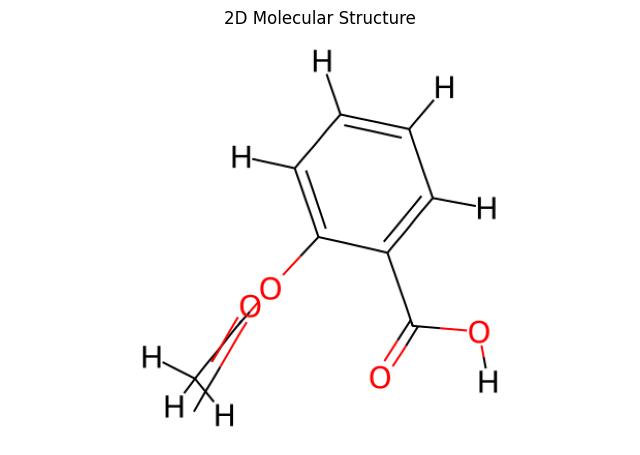


--- 3D Structure Visualization ---


3Dmol.js failed to load for some reason. Please check your browser console for error messages.

In [ ]:
def main():
    """Main function to run the molecular simulation with GNNs"""
    print("=== Molecular Property Prediction with Graph Neural Networks ===")

    # Get molecule name from user
    molecule_name = input("Enter the name of the molecule (e.g., benzene, aspirin): ")

    start_time = time.time()

    # Retrieve molecule
    print(f"\nRetrieving molecule '{molecule_name}' from PubChem...")
    mol, compound = get_molecule_from_name(molecule_name)

    if mol is None:
        print(f"Could not retrieve molecule: {molecule_name}")
        return

    print(f"\nSuccessfully retrieved molecule: {molecule_name}")

    # Get simulation parameters from user
    print("\n--- Configure Simulation Settings ---")

    # Properties to predict
    available_properties = [
        "Molecular Weight", "LogP", "Num H-Donors", "Num H-Acceptors",
        "Num Rotatable Bonds", "Topological Polar Surface Area",
        "Molar Refractivity", "Num Heavy Atoms"
    ]

    print("\nAvailable properties to predict:")
    for i, prop in enumerate(available_properties):
        print(f"{i+1}. {prop}")

    prop_indices = input("\nEnter the property numbers to predict (comma-separated, e.g., 1,2,3): ")
    selected_props = [available_properties[int(idx)-1] for idx in prop_indices.split(",")]

    # GNN hyperparameters
    hidden_dim = int(input("\nEnter hidden dimension size (recommended: 64-256): "))
    num_layers = int(input("Enter number of GNN layers (recommended: 2-4): "))
    noise_factor = float(input("Enter simulation noise factor (0.0-0.1, higher means more randomness): "))
    # Conformer analysis
    calc_conformers = input("\nPerform conformer analysis? (y/n): ").lower() == 'y'
    num_conformers = 10

    if calc_conformers:
        num_conformers = int(input("Enter number of conformers to generate (5-20): "))

    # Create simulation parameters dictionary
    simulation_params = {
        "properties_to_predict": selected_props,
        "hidden_dim": hidden_dim,
        "num_layers": num_layers,
        "noise_factor": noise_factor,
        "calculate_conformers": calc_conformers,
        "num_conformers": num_conformers
    }

    print("\nRunning simulation...")

    # Run simulation
    simulation_results = simulate_molecule_properties(mol, simulation_params)

    # Calculate elapsed time
    elapsed_time = time.time() - start_time
    print(f"\nSimulation completed in {elapsed_time:.2f} seconds")

    # Display results
    display_simulation_results(mol, compound, simulation_results)

# Run the main function
if __name__ == "__main__":
    main()
